# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns

# Functions definition

In [3]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf

# Read files : radiative budget, tas

In [24]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variables = ['rlut', 'rsut','rsdt','tas']

# The amip experiment : 

path=path_official
filename='*_amip_*.nc'
start_yr=1979
drop=True
year_list=range(1983,2015,1)
official_amip = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)

path=path_PPE+'CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
start_yr=1951
drop=False
year_list=None
#p1_amip = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)


nb_p_list = ['p105',  'p30',  'p65', \
'p15', \
'p109',  'p160',  'p34', \
'p111', \
'p36', \
'p122',  'p39',  'p83', \
'p123', \
'p88', \
'p184', \
'p131',  'p49', \
'p133',  'p193', \
'p13',  'p195',  'p93', \
'p140',    'p57', \
'p142',   'p58', \
'p144', \
'p148', \
'p14',   'p65']
N=len(nb_p_list)
start_yr=1979
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    print(nb_p)
    path=path_PPE+'CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p) + "_amip"] = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)
    i=i+1

p105
p30
p65
p15
p109
p160
p34
p111
p36
p122
p39
p83
p123
p88
p184
p131
p49
p133
p193
p13
p195
p93
p140
p57
p142
p58
p144
p148
p14
p65


In [25]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variables = ['rlut', 'rsut','rsdt','tas']

# The amip-future4K experiment : 

path=path_official
filename='*_amip-future4K_*.nc'
start_yr=1979
drop=True
year_list=range(1983,2015,1)
official_future4K = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)

path=path_PPE+'CNRM-CM6-1_amip-future4K_PPE/CNRM-CM6-1_amip-future4K_r1i1p1f2/'
start_yr=1951
drop=False
year_list=None
p1_future4K = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)


nb_p_list = ['p105',  'p30',  'p65', \
'p15', \
'p109',  'p160',  'p34', \
'p111', \
'p36', \
'p122',  'p39',  'p83', \
'p123', \
'p88', \
'p184', \
'p131',  'p49', \
'p133',  'p193', \
'p13',  'p195',  'p93', \
'p140',    'p57', \
'p142',   'p58', \
'p144', \
'p148', \
'p14',   'p65']
N=len(nb_p_list)
start_yr=1979
future4K={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    print(nb_p)
    path=path_PPE+'CNRM-CM6-1_amip-future4K_PPE/CNRM-CM6-1_amip-future4K_r1i1'+str(nb_p)+'f2/'
    future4K[str(nb_p) + "_future4k"] = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)
    i=i+1
    

p105
p30
p65
p15
p109
p160
p34
p111
p36
p122
p39
p83
p123
p88
p184
p131
p49
p133
p193
p13
p195
p93
p140
p57
p142
p58
p144
p148
p14
p65


In [10]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variables = ['rlut', 'rsut','rsdt','tas']

# The amip-future4K experiment, small ensemble 1950-1955 : 

path=path_official
filename='*_amip-future4K_*.nc'
start_yr=1979
drop=True
year_list=range(1989,2015,1)
official_future4K = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)

path=path_PPE+'CNRM-CM6-1_amip-future4K_PPE/CNRM-CM6-1_amip-future4K_r1i1p1f2/'
start_yr=1951
drop=False
year_list=None
p1_future4K1950 = get_wavg_budget_df(path, filename, variables, start_yr, drop, year_list)

start_yr=1950
nb_p_list1950 = ['p2',  'p4',  'p7', \
'p13',  'p14', \
'p15',  'p20',  'p30']
N=len(nb_p_list1950)
d1950={}
i = 0
while i<N:
    nb_p1950 = nb_p_list1950[i]
    print(nb_p1950)
    path=path_PPE+'CNRM-CM6-1_amip-future4K_PPE/1950-1955/'
    filename='*_amip-future4K_*'+nb_p1950+'f2_*.nc'
    d1950[str(nb_p1950) + "_future4k1950"] = get_wavg_budget_df(path, filename, variables, \
                                                                start_yr, drop, year_list)
    i=i+1
    

p2
p4
p7
p13
p14
p15
p20
p30


## Create plot

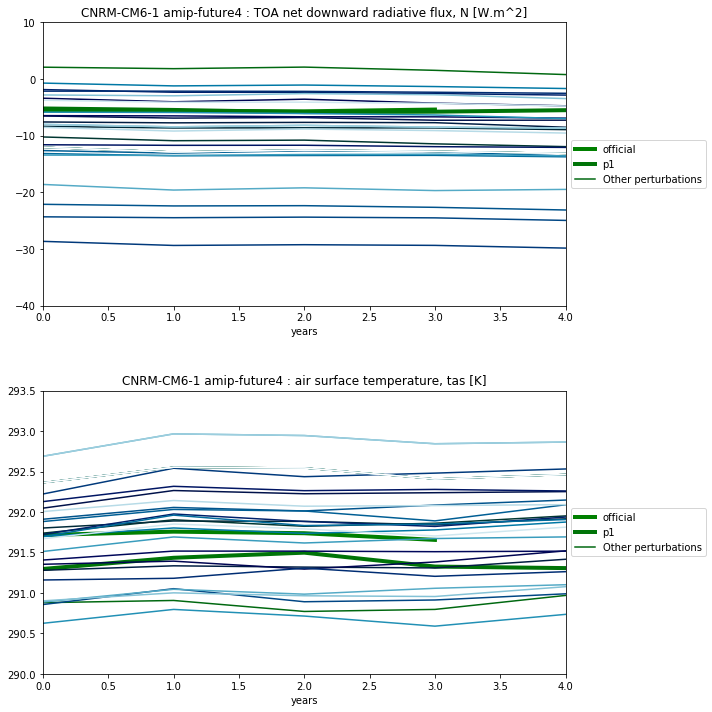

In [21]:
# PARAMETERS :
n=len(future4K)+2
df=[None]*n
df[0] = official_future4K
df[1] = p1_future4K
df[2:] = [future4K[i+"_future4k"] for i in nb_p_list]
cmap = plt.get_cmap('ocean')
colors = [cmap(i) for i in np.linspace(0, 1, len(df))]
linewidth = [4.0, 4.0]
i=0
N=len(df)
while i<N:
    linewidth.append(1.5)
    i=i+1
    
xlabel = 'years'
xmin = 0
xmax = 4
legend = ['official', 'p1', 'Other perturbations']

# Plot of lines from different dataframes
plt.subplots(figsize=(10,10)) 

plt.subplot(211)
title = 'CNRM-CM6-1 amip-future4 : TOA net downward radiative flux, N [W.m^2]'
y = 'N'
ymin = -40.0
ymax = 10.0
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax, legend)

plt.subplot(212)
title='CNRM-CM6-1 amip-future4 : air surface temperature, tas [K]'
y = 'tas'
ymin = 290.0
ymax = 293.5
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax, legend)

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

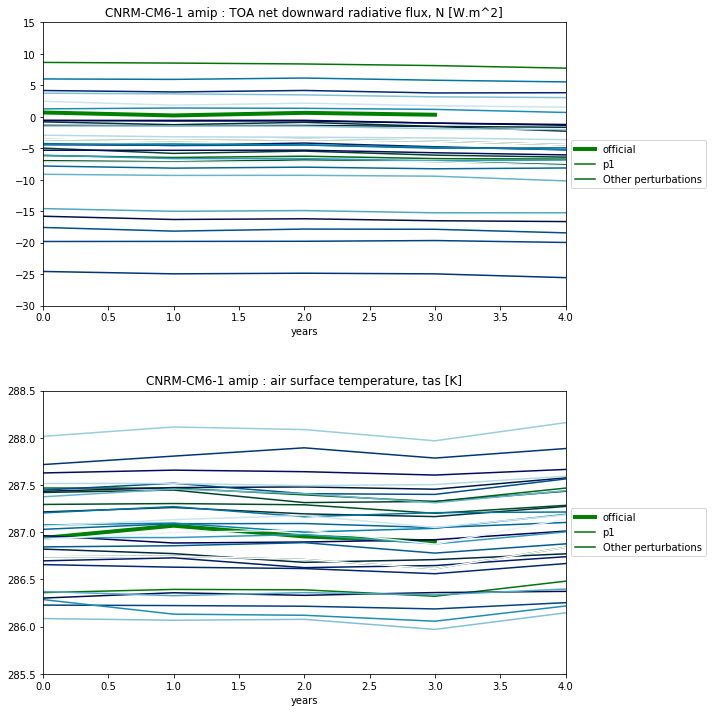

In [29]:
# PARAMETERS :
n=len(amip)+1
df=[None]*n
df[0] = official_amip
df[1:] = [amip[i+"_amip"] for i in nb_p_list]
cmap = plt.get_cmap('ocean')
colors = [cmap(i) for i in np.linspace(0, 1, len(df))]
linewidth = [4.0]
i=0
N=len(df)
while i<N:
    linewidth.append(1.5)
    i=i+1
    
xlabel = 'years'
xmin = 0
xmax = 4
legend = ['official', 'p1', 'Other perturbations']

# Plot of lines from different dataframes
plt.subplots(figsize=(10,10)) 

plt.subplot(211)
title = 'CNRM-CM6-1 amip : TOA net downward radiative flux, N [W.m^2]'
y = 'N'
ymin = -30.0
ymax = 15.0
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax, legend)

plt.subplot(212)
title='CNRM-CM6-1 amip : air surface temperature, tas [K]'
y = 'tas'
ymin = 285.5
ymax = 288.5
plotlines_Xdf(df, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax, legend)

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_amip.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

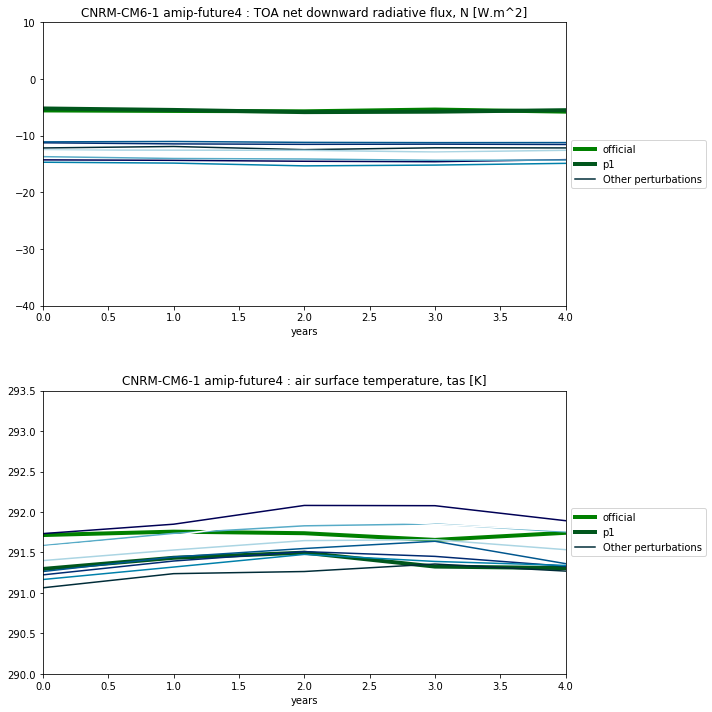

In [11]:
# PARAMETERS :
n=len(d1950)+2
df1950=[None]*n
df1950[0] = official_future4K
df1950[1] = p1_future4K1950
df1950[2:] = [d1950[i+"_future4k1950"] for i in nb_p_list1950]
cmap = plt.get_cmap('ocean')
colors = [cmap(i) for i in np.linspace(0, 1, len(df1950))]
linewidth = [4.0, 4.0]
i=0
N=len(df1950)
while i<N:
    linewidth.append(1.5)
    i=i+1
    
xlabel = 'years'
xmin = 0
xmax = 4
legend = ['official', 'p1', 'Other perturbations']

# Plot of lines from different dataframes
plt.subplots(figsize=(10,10)) 

plt.subplot(211)
title = 'CNRM-CM6-1 amip-future4 : TOA net downward radiative flux, N [W.m^2]'
y = 'N'
ymin = -40.0
ymax = 10.0
plotlines_1df(df1950, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax, legend)

plt.subplot(212)
title='CNRM-CM6-1 amip-future4 : air surface temperature, tas [K]'
y = 'tas'
ymin = 290.0
ymax = 293.5
plotlines_1df(df1950, y, title, colors, linewidth, xlabel, xmin, xmax, ymin, ymax, legend)

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/shortPPE_N_tas.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

# Compute : Delta(TOA), Delta(tas), Lambda

In [14]:
result= pd.DataFrame()

n=len(p1_future4K)

result = Deltas_Lambda(result, official_amip, official_future4K, 'official_future4K', n)
result = Deltas_Lambda(result, p1_amip, p1_future4K, 'p1_future4K', n)
result = Deltas_Lambda(result, p1bis_amip, p1_future4K, 'p1bis_future4K', n)
result = Deltas_Lambda(result, p2_amip, p2_future4K, 'p2_future4K', n)
result = Deltas_Lambda(result, p4_amip, p4_future4K, 'p4_future4K', n)
result = Deltas_Lambda(result, p7_amip, p7_future4K, 'p7_future4K', n)
result = Deltas_Lambda(result, p13_amip, p13_future4K, 'p13_future4K', n)
result = Deltas_Lambda(result, p14_amip, p14_future4K, 'p14_future4K', n)
result = Deltas_Lambda(result, p15_amip, p15_future4K, 'p15_future4K', n)
result = Deltas_Lambda(result, p20_amip, p20_future4K, 'p20_future4K', n)
result = Deltas_Lambda(result, p26_amip, p26_future4K, 'p26_future4K', n)
result = Deltas_Lambda(result, p30_amip, p30_future4K, 'p30_future4K', n)
result = Deltas_Lambda(result, p34_amip, p34_future4K, 'p34_future4K', n)

result

,Delta_N_official_future4K,Delta_tas_official_future4K,Lambda_official_future4K,Delta_N_p1_future4K,Delta_tas_p1_future4K,Lambda_p1_future4K,Delta_N_p1bis_future4K,Delta_tas_p1bis_future4K,Lambda_p1bis_future4K,Delta_N_p2_future4K,...,Lambda_p20_future4K,Delta_N_p26_future4K,Delta_tas_p26_future4K,Lambda_p26_future4K,Delta_N_p30_future4K,Delta_tas_p30_future4K,Lambda_p30_future4K,Delta_N_p34_future4K,Delta_tas_p34_future4K,Lambda_p34_future4K
0,-6.799255,4.998291,-1.360316,-5.643677,5.096466,-1.107371,-6.103241,4.705658,-1.297001,-6.806152,...,-1.598626,-6.840271,4.392395,-1.557299,-6.318665,4.191345,-1.507550,-5.985840,4.471832,-1.338565
1,-6.639771,4.865326,-1.364712,-5.754974,5.254288,-1.095291,-6.240265,4.659286,-1.339318,-6.711136,...,-1.557846,-6.796127,4.476364,-1.518225,-6.272995,4.296112,-1.460156,-6.287598,4.544739,-1.383489
2,-6.727458,4.892527,-1.375048,-5.950185,5.268829,-1.129318,-6.403595,4.684153,-1.367076,-6.738078,...,-1.507166,-6.842295,4.597565,-1.488243,-6.504883,4.461710,-1.457935,-6.433858,4.594238,-1.400419
3,-6.676025,4.886787,-1.366138,-5.857979,5.204964,-1.125460,-6.380661,4.689301,-1.360685,-6.636566,...,-1.509674,-6.887344,4.675415,-1.473098,-6.494705,4.518021,-1.437511,-6.430138,4.619942,-1.391822
4,-6.596069,4.838654,-1.363204,-5.810486,5.207953,-1.115695,-6.415076,4.720587,-1.358957,-6.625684,...,-1.502223,-6.944171,4.690173,-1.480579,-6.472620,4.569440,-1.416502,-6.383655,4.606433,-1.385813


# Create plot

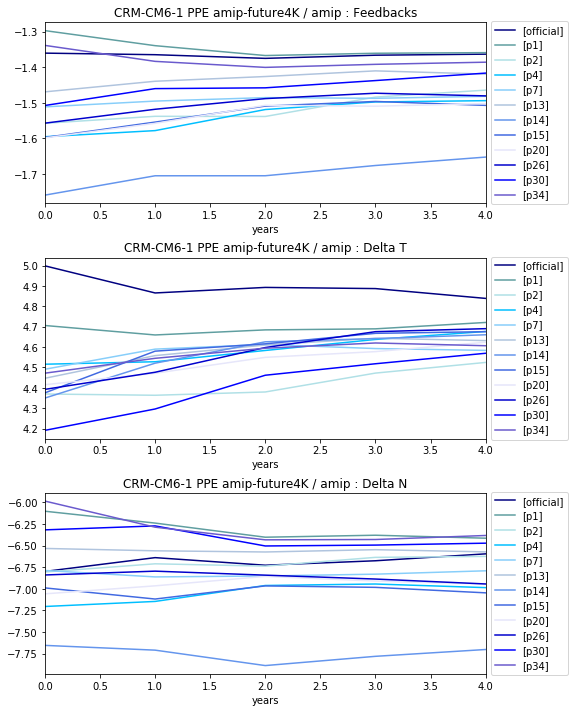

In [18]:
# PARAMETERS
df = result
colors=['navy','cadetblue','powderblue','deepskyblue','lightskyblue', 'lightsteelblue', 'cornflowerblue', 
        'royalblue', 'lavender', 'mediumblue', 'blue', 'slateblue']
xlabel='years'
xmin = 0
xmax = 4
legend=['[official]','[p1]','[p2]','[p4]', '[p7]', '[p13]', '[p14]', '[p15]', '[p20]', '[p26]', '[p30]', '[p34]']


#--------------------------- Plot result : future4K --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
title="CRM-CM6-1 PPE amip-future4K / amip : Feedbacks"
y = ['Lambda_official_future4K','Lambda_p1bis_future4K','Lambda_p2_future4K',
                    'Lambda_p4_future4K','Lambda_p7_future4K','Lambda_p13_future4K',
                    'Lambda_p14_future4K','Lambda_p15_future4K','Lambda_p20_future4K','Lambda_p26_future4K',
                    'Lambda_p30_future4K', 'Lambda_p34_future4K']
plotlines_Xdf(df, y , xmin, xmax, title, colors, xlabel, legend )

plt.subplot(312)
title='CRM-CM6-1 PPE amip-future4K / amip : Delta T'
y = ['Delta_tas_official_future4K','Delta_tas_p1bis_future4K','Delta_tas_p2_future4K',
                    'Delta_tas_p4_future4K','Delta_tas_p7_future4K', 'Delta_tas_p13_future4K', 
                    'Delta_tas_p14_future4K', 'Delta_tas_p15_future4K', 'Delta_tas_p20_future4K', 
                    'Delta_tas_p26_future4K', 'Delta_tas_p30_future4K', 'Delta_tas_p34_future4K']
plotlines_Xdf(df, y , xmin, xmax, title, colors, xlabel, legend )

plt.subplot(313)
title='CRM-CM6-1 PPE amip-future4K / amip : Delta N'
y = ['Delta_N_official_future4K','Delta_N_p1bis_future4K','Delta_N_p2_future4K',
                    'Delta_N_p4_future4K','Delta_N_p7_future4K', 'Delta_N_p13_future4K', 'Delta_N_p14_future4K',
                   'Delta_N_p15_future4K', 'Delta_N_p20_future4K', 'Delta_N_p26_future4K', 'Delta_N_p30_future4K',
                   'Delta_N_p34_future4K']
plotlines_Xdf(df, y , xmin, xmax, title, colors, xlabel, legend )

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_DT_DN.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Pair plot analyse of parameter / feedbacks

Here we want to compute the averaged feedbacks (over 5 years) given by each parameter set, and put this information into a matrice parmaeter values / feedbacks. This matrix will be then transformed into pair plot to see wich parameter values give high/ low feedbacks values.

In [19]:
# Read the .csv file with parameter values
PPE_future4K = pd.read_csv('/data/home/globc/peatier/CNRMppe/crash_emulator/crash_amip-future4K.csv', sep=';').drop(['t_IDs'],axis=1)
PPE_future4K

,Y,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,...,VVN,VVX,ALFX,REFLCAPE,FNEBC,GCVTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ
0,1,0.175049,1.488544,1.449805,15.532379,-0.238847,2.270914,5.235486,0.006996,0.000441,...,-3.147981,-38.083048,0.071004,6.731691,14.254849,0.000063,0.864952,0.677901,0.768799,0.744990
1,1,0.167680,1.880158,1.973222,14.357632,-0.250957,4.865664,7.353332,0.006406,0.000642,...,-4.301296,-32.742882,0.056741,4.810351,12.882991,0.000074,0.802851,0.616178,0.800514,0.733552
2,0,0.173487,2.086636,2.070605,21.338777,-0.278889,2.642393,4.222709,0.008153,0.000210,...,-3.440333,-33.880859,0.074964,6.226616,3.646718,0.000077,0.779812,0.660804,0.648204,0.738744
3,0,0.160021,2.370838,1.835850,15.060141,-0.301109,5.391311,3.782260,0.003023,0.000394,...,-4.611250,-35.147508,0.088527,5.486981,8.104176,0.000077,0.906631,0.754324,0.828823,0.746475
4,1,0.134186,1.724029,1.558606,8.468488,-0.134411,3.785087,4.299384,0.006238,0.000546,...,-2.639630,-38.810282,0.042651,7.476803,11.590295,0.000063,0.831459,0.778510,0.715348,0.721524
5,0,0.089940,1.688791,1.359688,15.149782,-0.261029,5.571734,8.305617,0.005397,0.000431,...,-3.645456,-35.836482,0.068189,6.074601,6.629867,0.000088,0.845729,0.781436,0.729203,0.549863
6,0,0.155451,1.518791,1.813654,10.955609,-0.193977,7.197070,7.324802,0.005024,0.000464,...,-3.106581,-37.815645,0.111743,2.689894,7.348396,0.000051,0.883923,0.812567,0.703568,0.950552
7,0,0.187178,1.705342,1.114969,4.635560,-0.158832,5.517904,2.871048,0.006467,0.000423,...,-3.376322,-33.514452,0.113822,7.792097,3.671617,0.000085,0.745013,0.720633,0.856047,0.892610
8,1,0.122512,1.736421,1.664926,16.186006,-0.289847,1.653443,3.206756,0.006433,0.000143,...,-2.836616,-32.393887,0.065509,4.725514,17.238794,0.000051,0.810301,0.651767,0.773940,0.770508
9,1,0.225561,0.973960,2.530197,17.655355,-0.180858,3.555748,6.561043,0.005736,0.000540,...,-2.458276,-33.064101,0.055070,7.168388,12.327390,0.000059,0.749880,0.706037,0.839475,0.681345


In [20]:
seuil=-1.5
feedbacks=[]
crashes=[]
i=0
j=0
N=len(PPE_future4K)
names=['p2','p4', 'p7', 'p13', 'p14', 'p15', 'p20', 'p26', 'p30', 'p34']

while i<N:
    tmp_PPE=PPE_future4K.iloc[i]
    if tmp_PPE['Y']==1:
        name='Lambda_'+names[j]+'_future4K'
        tmp_lambda=result[name].mean()
        feedbacks.append(tmp_lambda)
        j= (j+1)
    else :
        crashes.append(i)
    i = (i+1)

PPE_future4K=PPE_future4K.drop(PPE_future4K.index[crashes])
PPE_future4K['feedbacks']=feedbacks
PPE_future4K

,Y,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,...,VVX,ALFX,REFLCAPE,FNEBC,GCVTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,feedbacks
0,1,0.175049,1.488544,1.449805,15.532379,-0.238847,2.270914,5.235486,0.006996,0.000441,...,-38.083048,0.071004,6.731691,14.254849,0.000063,0.864952,0.677901,0.768799,0.744990,-1.516503
1,1,0.167680,1.880158,1.973222,14.357632,-0.250957,4.865664,7.353332,0.006406,0.000642,...,-32.742882,0.056741,4.810351,12.882991,0.000074,0.802851,0.616178,0.800514,0.733552,-1.536875
4,1,0.134186,1.724029,1.558606,8.468488,-0.134411,3.785087,4.299384,0.006238,0.000546,...,-38.810282,0.042651,7.476803,11.590295,0.000063,0.831459,0.778510,0.715348,0.721524,-1.492267
8,1,0.122512,1.736421,1.664926,16.186006,-0.289847,1.653443,3.206756,0.006433,0.000143,...,-32.393887,0.065509,4.725514,17.238794,0.000051,0.810301,0.651767,0.773940,0.770508,-1.432849
9,1,0.225561,0.973960,2.530197,17.655355,-0.180858,3.555748,6.561043,0.005736,0.000540,...,-33.064101,0.055070,7.168388,12.327390,0.000059,0.749880,0.706037,0.839475,0.681345,-1.699899
10,1,0.222520,1.440312,2.461353,17.788514,-0.383543,5.346754,6.985773,0.003597,0.000367,...,-36.583862,0.062217,5.286281,9.520389,0.000044,0.545771,0.948313,0.793099,0.924137,-1.532941
13,1,0.220874,1.350418,1.284243,10.720732,-0.342713,5.048791,4.071926,0.004416,0.000498,...,-31.538635,0.103941,6.687661,6.788066,0.000060,0.729552,0.666081,0.933773,0.633442,-1.535107
15,1,0.142649,1.512349,2.097264,8.108691,-0.224078,8.077058,5.759029,0.007708,0.000786,...,-36.297646,0.052415,5.736289,7.295755,0.000031,0.687496,0.870209,0.675731,0.637530,-1.503489
17,1,0.204041,1.585514,1.784973,15.264949,-0.129485,6.838859,4.629554,0.004500,0.000127,...,-35.648769,0.077763,7.775841,15.449353,0.000074,0.764999,0.611928,0.834043,0.943710,-1.455931
19,1,0.151299,1.349612,0.754833,5.378710,-0.124832,4.910836,7.231358,0.003139,0.000761,...,-36.064561,0.063878,6.208712,11.622177,0.000026,0.948113,0.667139,0.844987,0.683252,-1.380022


In [21]:
# Save the parameters names in a list 
param_names=list(PPE_future4K.columns.values)
#param_names

In [22]:
max=PPE_future4K['feedbacks'].max()
min=PPE_future4K['feedbacks'].min()
min

-1.6998991966247559

In [23]:
i=0
N=len(PPE_future4K)
feed=[]
seuil=-1.5

while i<N:
    tmp_df=PPE_future4K.iloc[i]
    if tmp_df['feedbacks'] < seuil:
        if tmp_df['feedbacks'] == min:
            feed.append(0.0)
        else:
            feed.append(1.0)
    elif tmp_df['feedbacks'] > seuil:
        if tmp_df['feedbacks'] == max:
            feed.append(3.0)
        else :
            feed.append(2.0)
    i = (i+1)

PPE_future4K['feedbacks_class']=feed
PPE_future4K

,Y,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,...,ALFX,REFLCAPE,FNEBC,GCVTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,feedbacks,feedbacks_class
0,1,0.175049,1.488544,1.449805,15.532379,-0.238847,2.270914,5.235486,0.006996,0.000441,...,0.071004,6.731691,14.254849,0.000063,0.864952,0.677901,0.768799,0.744990,-1.516503,1.0
1,1,0.167680,1.880158,1.973222,14.357632,-0.250957,4.865664,7.353332,0.006406,0.000642,...,0.056741,4.810351,12.882991,0.000074,0.802851,0.616178,0.800514,0.733552,-1.536875,1.0
4,1,0.134186,1.724029,1.558606,8.468488,-0.134411,3.785087,4.299384,0.006238,0.000546,...,0.042651,7.476803,11.590295,0.000063,0.831459,0.778510,0.715348,0.721524,-1.492267,2.0
8,1,0.122512,1.736421,1.664926,16.186006,-0.289847,1.653443,3.206756,0.006433,0.000143,...,0.065509,4.725514,17.238794,0.000051,0.810301,0.651767,0.773940,0.770508,-1.432849,2.0
9,1,0.225561,0.973960,2.530197,17.655355,-0.180858,3.555748,6.561043,0.005736,0.000540,...,0.055070,7.168388,12.327390,0.000059,0.749880,0.706037,0.839475,0.681345,-1.699899,0.0
10,1,0.222520,1.440312,2.461353,17.788514,-0.383543,5.346754,6.985773,0.003597,0.000367,...,0.062217,5.286281,9.520389,0.000044,0.545771,0.948313,0.793099,0.924137,-1.532941,1.0
13,1,0.220874,1.350418,1.284243,10.720732,-0.342713,5.048791,4.071926,0.004416,0.000498,...,0.103941,6.687661,6.788066,0.000060,0.729552,0.666081,0.933773,0.633442,-1.535107,1.0
15,1,0.142649,1.512349,2.097264,8.108691,-0.224078,8.077058,5.759029,0.007708,0.000786,...,0.052415,5.736289,7.295755,0.000031,0.687496,0.870209,0.675731,0.637530,-1.503489,1.0
17,1,0.204041,1.585514,1.784973,15.264949,-0.129485,6.838859,4.629554,0.004500,0.000127,...,0.077763,7.775841,15.449353,0.000074,0.764999,0.611928,0.834043,0.943710,-1.455931,2.0
19,1,0.151299,1.349612,0.754833,5.378710,-0.124832,4.910836,7.231358,0.003139,0.000761,...,0.063878,6.208712,11.622177,0.000026,0.948113,0.667139,0.844987,0.683252,-1.380022,3.0


In [24]:
i=0
N=len(PPE_future4K)
feed=[]
seuil=-1.5

while i<N:
    tmp_df=PPE_future4K.iloc[i]
    if tmp_df['feedbacks'] < seuil:
        feed.append(0.0)
    elif tmp_df['feedbacks'] > seuil:
        feed.append(1.0)
    i = (i+1)

PPE_future4K['feedbacks_class']=feed
PPE_future4K

,Y,AKN,ALPHAT,ALD,ALMAVE,AGREF,AGRE1,AGRE2,RAUTEFR,RQLCR,...,ALFX,REFLCAPE,FNEBC,GCVTURB,RLWINHF_ICE,RLWINHF_LIQ,RSWINHF_ICE,RSWINHF_LIQ,feedbacks,feedbacks_class
0,1,0.175049,1.488544,1.449805,15.532379,-0.238847,2.270914,5.235486,0.006996,0.000441,...,0.071004,6.731691,14.254849,0.000063,0.864952,0.677901,0.768799,0.744990,-1.516503,0.0
1,1,0.167680,1.880158,1.973222,14.357632,-0.250957,4.865664,7.353332,0.006406,0.000642,...,0.056741,4.810351,12.882991,0.000074,0.802851,0.616178,0.800514,0.733552,-1.536875,0.0
4,1,0.134186,1.724029,1.558606,8.468488,-0.134411,3.785087,4.299384,0.006238,0.000546,...,0.042651,7.476803,11.590295,0.000063,0.831459,0.778510,0.715348,0.721524,-1.492267,1.0
8,1,0.122512,1.736421,1.664926,16.186006,-0.289847,1.653443,3.206756,0.006433,0.000143,...,0.065509,4.725514,17.238794,0.000051,0.810301,0.651767,0.773940,0.770508,-1.432849,1.0
9,1,0.225561,0.973960,2.530197,17.655355,-0.180858,3.555748,6.561043,0.005736,0.000540,...,0.055070,7.168388,12.327390,0.000059,0.749880,0.706037,0.839475,0.681345,-1.699899,0.0
10,1,0.222520,1.440312,2.461353,17.788514,-0.383543,5.346754,6.985773,0.003597,0.000367,...,0.062217,5.286281,9.520389,0.000044,0.545771,0.948313,0.793099,0.924137,-1.532941,0.0
13,1,0.220874,1.350418,1.284243,10.720732,-0.342713,5.048791,4.071926,0.004416,0.000498,...,0.103941,6.687661,6.788066,0.000060,0.729552,0.666081,0.933773,0.633442,-1.535107,0.0
15,1,0.142649,1.512349,2.097264,8.108691,-0.224078,8.077058,5.759029,0.007708,0.000786,...,0.052415,5.736289,7.295755,0.000031,0.687496,0.870209,0.675731,0.637530,-1.503489,0.0
17,1,0.204041,1.585514,1.784973,15.264949,-0.129485,6.838859,4.629554,0.004500,0.000127,...,0.077763,7.775841,15.449353,0.000074,0.764999,0.611928,0.834043,0.943710,-1.455931,1.0
19,1,0.151299,1.349612,0.754833,5.378710,-0.124832,4.910836,7.231358,0.003139,0.000761,...,0.063878,6.208712,11.622177,0.000026,0.948113,0.667139,0.844987,0.683252,-1.380022,1.0


In [25]:
print(PPE_future4K['feedbacks_class'])

0     0.0
1     0.0
4     1.0
8     1.0
9     0.0
10    0.0
13    0.0
15    0.0
17    1.0
19    1.0
Name: feedbacks_class, dtype: float64


## Create Pair Plot

In [26]:
# Definition d'une fonction pour un meilleur scattering (problème d'échelle sur l'axe y dans sns.pairplot)
def better_scatter(x, y, **kwargs):
    sns.scatterplot(x, y, **kwargs, alpha=alpha)
    max_y = y.max()
    min_y = y.min()
    margin = (max_y - min_y) * 0.1
    plt.ylim(min_y - margin, max_y + margin)
    #print(max_y)
    #print(min_y)
    #print(margin)

In [27]:
# Definition fonction Pair plot :
import seaborn as sns
import matplotlib.pyplot as plt

def pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title):

    g = sns.pairplot(df[list_param], hue=hue,
            palette=list_colors,vars=list_vars, diag_kind='hist', diag_kws = {'alpha': alpha}, 
                    plot_kws = {'alpha': alpha})

    g = g.map_offdiag(better_scatter)

    handles = g._legend_data.values()
    #labels = g._legend_data.keys()
    g._legend.remove()
    g.fig.legend(handles=handles, 
             labels=labels,
             loc='lower left', ncol=5, fontsize=15, markerscale=2)
    g.fig.subplots_adjust(top=0.92, bottom=0.08)

    # Title 
    plt.suptitle(title, size = 28)
    #plt.legend(labels)
    
    #plt.show()

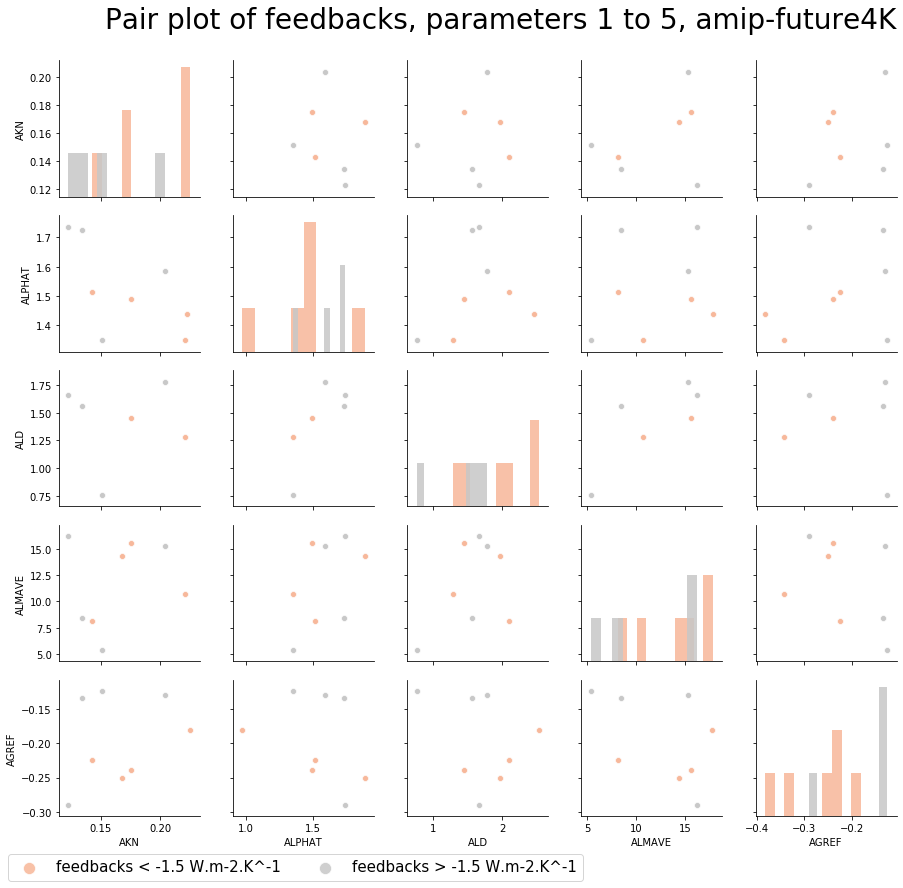

In [28]:
# PARAMETERS 

df=PPE_future4K
list_param=param_names[1:6]
list_param.append('feedbacks_class')
hue='feedbacks_class'
markers=["o","o"]
list_colors='RdGy'
list_vars=param_names[1:6]
alpha=0.85
labels=["feedbacks < -1.5 W.m-2.K^-1","feedbacks > -1.5 W.m-2.K^-1"]
title='Pair plot of feedbacks, parameters 1 to 5, amip-future4K'

# Figure
pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_pairplot1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

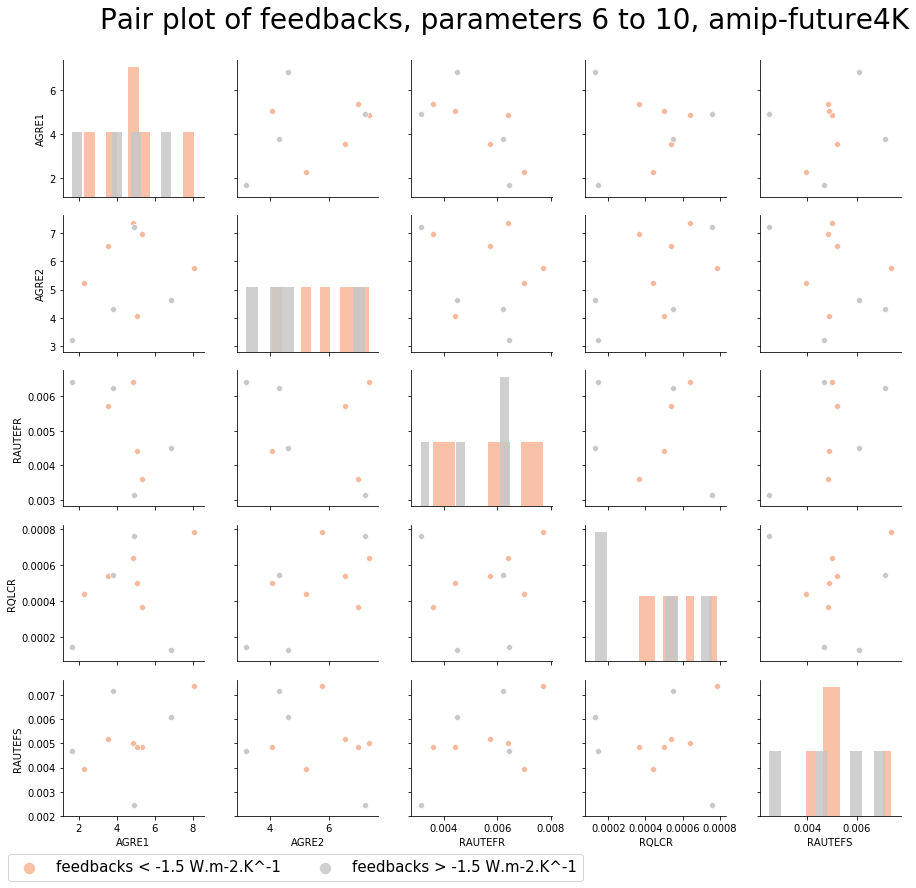

In [16]:
df=PPE_future4K
list_param=param_names[6:11]
list_param.append('feedbacks_class')
hue='feedbacks_class'
markers=["o","o"]
list_colors='RdGy'
list_vars=param_names[6:11]
alpha=0.85
labels=["feedbacks < -1.5 W.m-2.K^-1","feedbacks > -1.5 W.m-2.K^-1"]
title='Pair plot of feedbacks, parameters 6 to 10, amip-future4K'
pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_pairplot2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

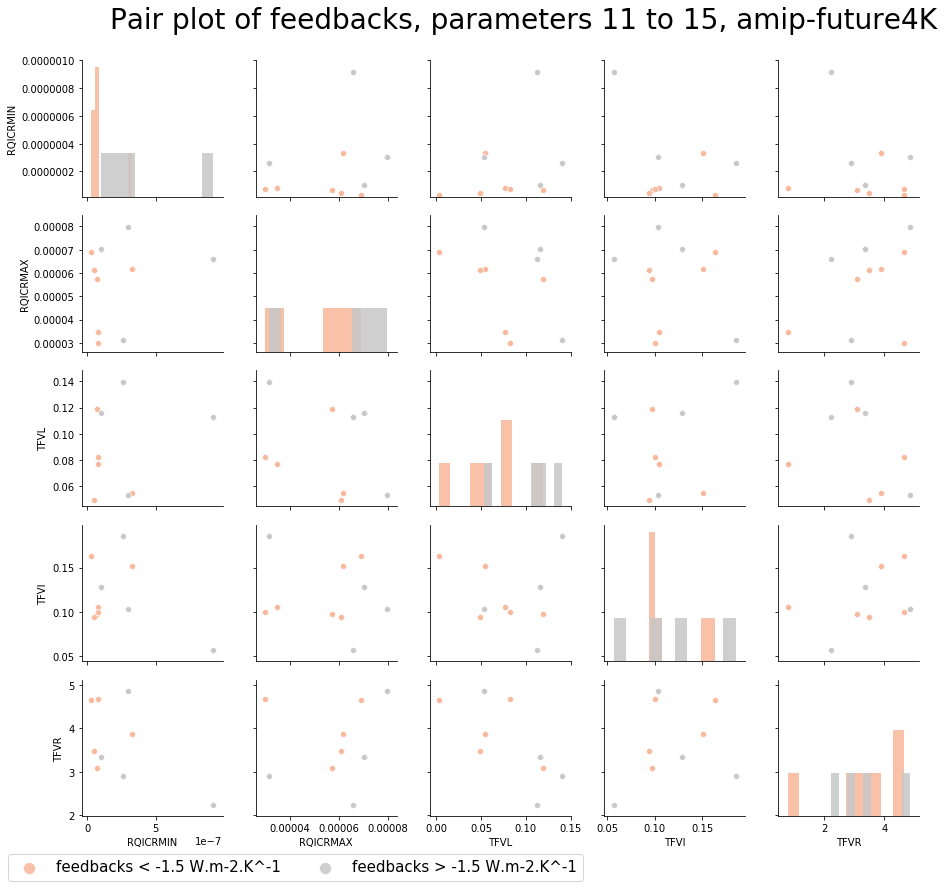

In [17]:
df=PPE_future4K
list_param=param_names[11:16]
list_param.append('feedbacks_class')
hue='feedbacks_class'
markers=["o","o"]
list_colors='RdGy'
list_vars=param_names[11:16]
alpha=0.85
labels=["feedbacks < -1.5 W.m-2.K^-1","feedbacks > -1.5 W.m-2.K^-1"]
title='Pair plot of feedbacks, parameters 11 to 15, amip-future4K'
pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_pairplot3.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

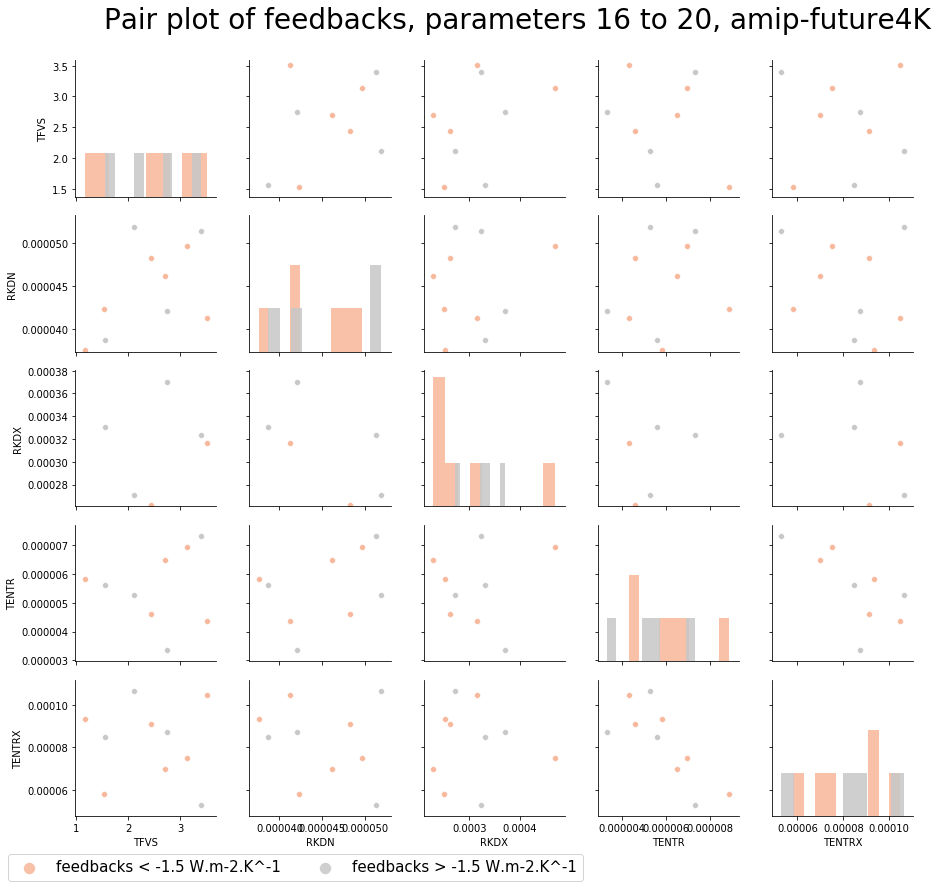

In [18]:
df=PPE_future4K
list_param=param_names[16:21]
list_param.append('feedbacks_class')
hue='feedbacks_class'
markers=["o","o"]
list_colors='RdGy'
list_vars=param_names[16:21]
alpha=0.85
labels=["feedbacks < -1.5 W.m-2.K^-1","feedbacks > -1.5 W.m-2.K^-1"]
title='Pair plot of feedbacks, parameters 16 to 20, amip-future4K'
pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_pairplot4.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

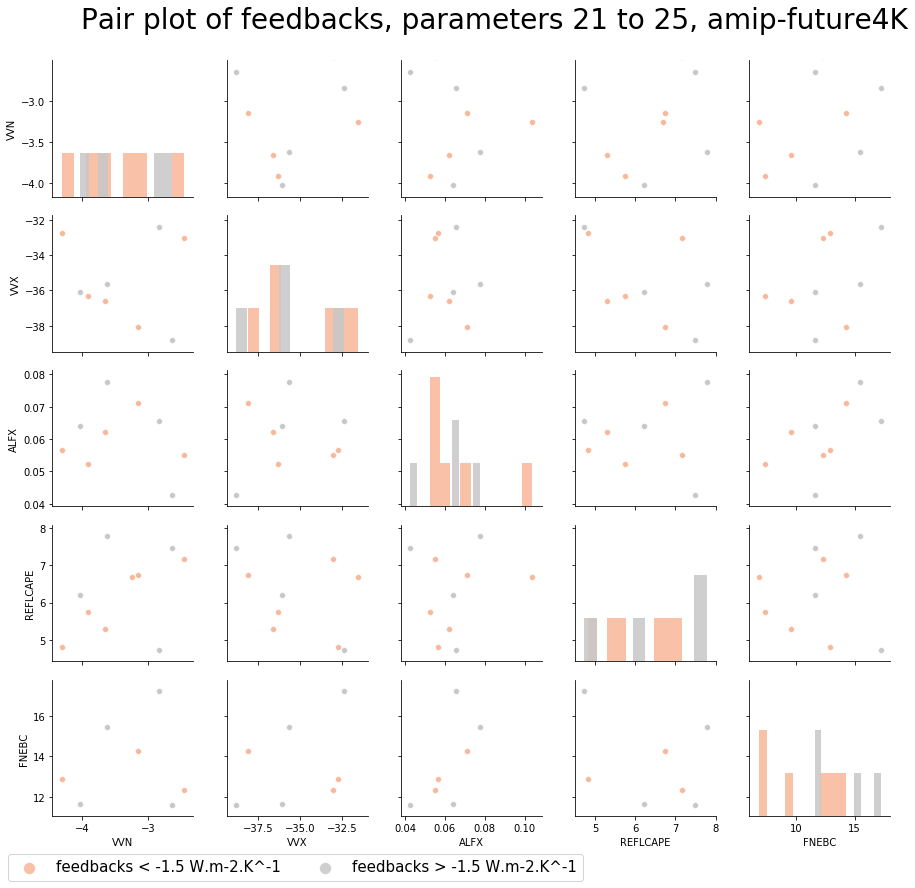

In [19]:
df=PPE_future4K
list_param=param_names[21:26]
list_param.append('feedbacks_class')
hue='feedbacks_class'
markers=["o","o"]
list_colors='RdGy'
list_vars=param_names[21:26]
alpha=0.85
labels=["feedbacks < -1.5 W.m-2.K^-1","feedbacks > -1.5 W.m-2.K^-1"]
title='Pair plot of feedbacks, parameters 21 to 25, amip-future4K'
pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_pairplot5.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()

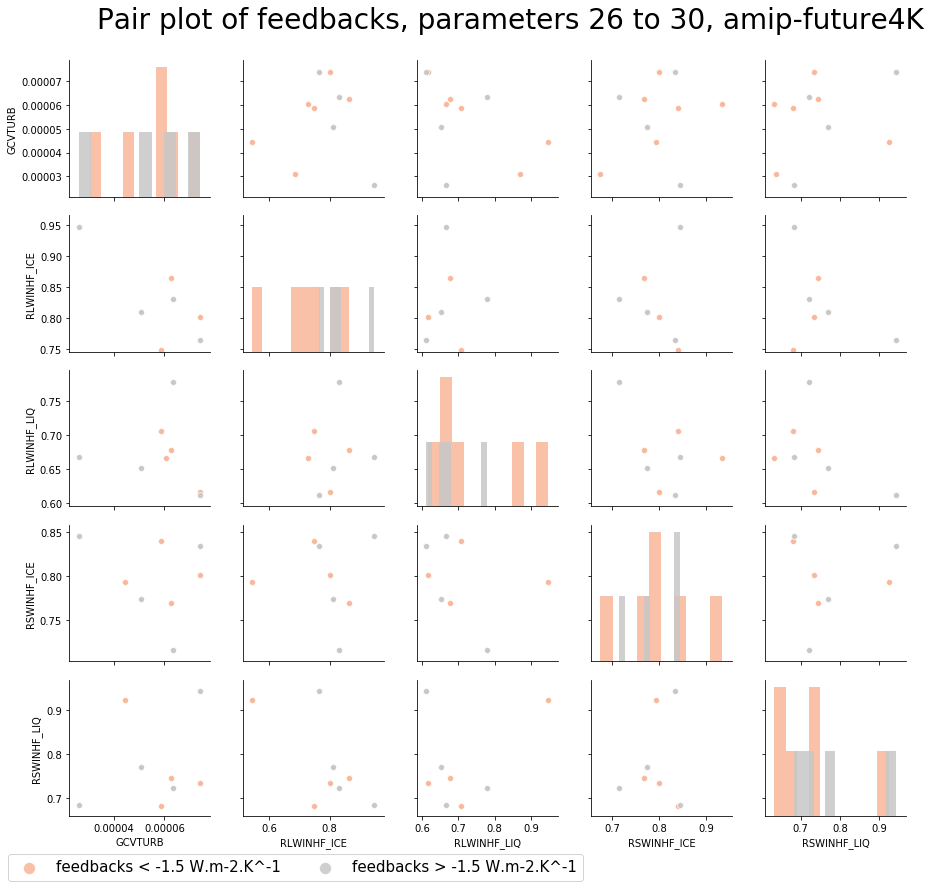

In [20]:
df=PPE_future4K
list_param=param_names[26:31]
list_param.append('feedbacks_class')
hue='feedbacks_class'
markers=["o","o"]
list_colors='RdGy'
list_vars=param_names[26:31]
alpha=0.85
labels=["feedbacks < -1.5 W.m-2.K^-1","feedbacks > -1.5 W.m-2.K^-1"]
title='Pair plot of feedbacks, parameters 26 to 30, amip-future4K'
pairplot(df, list_param, hue, list_colors, list_vars, alpha, labels, title)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_feedbacks_pairplot6.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show plot 
plt.show()